In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np

import geopandas as gpd
from shapely.geometry import Point
from geopandas import GeoDataFrame
import matplotlib.pyplot as plt

from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

from sklearn.preprocessing import LabelEncoder

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import log_loss

In [3]:
train_data = pd.read_csv("/content/drive/MyDrive/Kaggle_study/Sanfrancisco_Crime_Classification/train.csv.zip")
train_data

,Dates,Category,Descript,DayOfWeek,PdDistrict,Resolution,Address,X,Y
0,2015-05-13 23:53:00,WARRANTS,WARRANT ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
1,2015-05-13 23:53:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",OAK ST / LAGUNA ST,-122.425892,37.774599
2,2015-05-13 23:33:00,OTHER OFFENSES,TRAFFIC VIOLATION ARREST,Wednesday,NORTHERN,"ARREST, BOOKED",VANNESS AV / GREENWICH ST,-122.424363,37.800414
3,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,NORTHERN,NONE,1500 Block of LOMBARD ST,-122.426995,37.800873
4,2015-05-13 23:30:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Wednesday,PARK,NONE,100 Block of BRODERICK ST,-122.438738,37.771541
...,...,...,...,...,...,...,...,...,...
878044,2003-01-06 00:15:00,ROBBERY,ROBBERY ON THE STREET WITH A GUN,Monday,TARAVAL,NONE,FARALLONES ST / CAPITOL AV,-122.459033,37.714056
878045,2003-01-06 00:01:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Monday,INGLESIDE,NONE,600 Block of EDNA ST,-122.447364,37.731948
878046,2003-01-06 00:01:00,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Monday,SOUTHERN,NONE,5TH ST / FOLSOM ST,-122.403390,37.780266
878047,2003-01-06 00:01:00,VANDALISM,"MALICIOUS MISCHIEF, VANDALISM OF VEHICLES",Monday,SOUTHERN,NONE,TOWNSEND ST / 2ND ST,-122.390531,37.780607


### 데이터 필드   

**날짜**: 범죄 사건의 타임스탬프   
**범주**: 범죄 사건의 범주   
**설명**: 범죄 사건에 대한 자세한 설명   
**요일**: 요일   
**PDDistrict**: 경찰서 지구 이름   
**해결책**: 범죄 사건이 해결된 방법   
**주소**: 범죄 사건의 대략적인 거리 주소   
**X**: 경도   
**Y**: 위도   

## Data Types

In [4]:
train_data.dtypes

Dates          object
Category       object
Descript       object
DayOfWeek      object
PdDistrict     object
Resolution     object
Address        object
X             float64
Y             float64
dtype: object

## Data Processing
### Duplicated data

In [5]:
train_data.duplicated().sum()

2323

In [6]:
train_data.drop_duplicates(keep="first", inplace=True)

## Outliers
샌프란시스코 바깥쪽에 잘못 표시된 좌표가 있습니다

<ipython-input-7-5bc1aa4ed972>:4: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


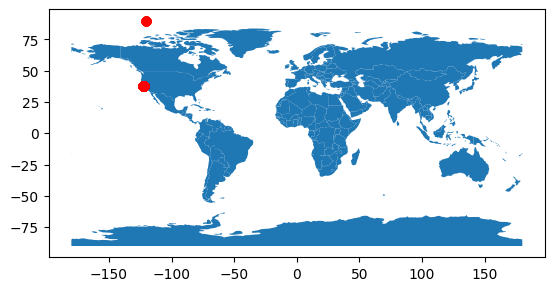

In [7]:
geometry = [Point(xy) for xy in zip(train_data['X'], train_data['Y'])]
gdf = GeoDataFrame(train_data, geometry=geometry)

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(ax=world.plot(), marker='o', color='red')
plt.show()

In [8]:
train_data[(train_data.X > -122) | (train_data.X < -123) | (train_data.Y > 38) | (train_data.Y < 37)].count()[0]

67

잘못된 레이블이 지정된 모든 데이터를 데이터 세트에서 삭제

In [9]:
train_data = train_data.drop(train_data[(train_data.X > -122) | (train_data.X < -123) | (train_data.Y > 38) | (train_data.Y < 37)].index)

"날짜" 열에서 연도, 월, 일, 시간을 구문 분석한다.

In [10]:
dates = pd.to_datetime(train_data["Dates"])
train_data["Year"] = dates.dt.year
train_data["Month"] = dates.dt.month
train_data["Day"] = dates.dt.day
train_data["Hour"] = dates.dt.hour

날짜를 기준으로 공휴일인지 판단할 수 있습니다.

In [11]:
holidays = calendar().holidays(start=train_data["Dates"].min(), end=train_data["Dates"].max())
train_data["Holiday"] = dates.astype("datetime64").isin(holidays)

<ipython-input-11-5a00b9c6dc60>:2: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  train_data["Holiday"] = dates.astype("datetime64").isin(holidays)


주말인지 판단

In [12]:
def weekend(weekday):
    return weekday == "Saturday" or weekday == "Sunday"

train_data["Weekend"] = train_data["DayOfWeek"].map(weekend)

### Label Encoding

In [13]:
le = LabelEncoder()
train_data["Category_Label"] = le.fit_transform(train_data["Category"])
train_data["DayOfWeek_Label"] = le.fit_transform(train_data["DayOfWeek"])
train_data["PdDistrict_Label"] = le.fit_transform(train_data["PdDistrict"])

train_data = train_data.drop(columns=["Category", "DayOfWeek", "PdDistrict"])

### Data cleaning
Remove some irrelavent or no longer useful information.


In [14]:
train_data = train_data.drop(columns=["Dates", "Address", "Resolution", "Descript"])
train_data.dropna(inplace=True)

## Model
### Prepare data

In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    train_data.drop("Category_Label", axis=1),
    train_data["Category_Label"],
    stratify=train_data["Category_Label"],
    test_size=0.3,
    random_state=1
)

Random Forest

In [16]:
random_forest_model = RandomForestClassifier(
    n_estimators=60,
    max_depth=32,
    random_state=1
)

### KNN

In [16]:
knn_model = KNeighborsClassifier(n_neighbors=9)

### Results

In [17]:
def model_result(model):
    train_acc = model.score(X_train, y_train)
    train_loss = log_loss(y_train, model.predict_proba(X_train))
    test_acc = model.score(X_test, y_test)
    test_loss = log_loss(y_test, model.predict_proba(X_test))

    return train_acc, train_loss, test_acc, test_loss

### Random Forest

In [ ]:
random_forest_model.fit(X_train, y_train)
print(model_result(random_forest_model))

### KNN

In [18]:
knn_model.fit(X_train, y_train)
print(model_result(knn_model))

(0.3354781136157113, 1.6349440429990179, 0.1864308064773999, 15.316750626952645)
